# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(azdias.shape)
azdias.head(10)

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [4]:
print(feat_info.shape)
feat_info

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.isna().sum().sum()

4896838

In [6]:
def string_to_int_if_number(row):
    inputs = row[1]['missing_or_unknown'].strip('[').strip(']').split(',')
    outputs = []
    for x in inputs:
        if x.strip('-').isnumeric():
            outputs.append(int(x))
        else:
            outputs.append(x)
    return outputs

In [7]:
missing_value_dict = {row[1]['attribute']:string_to_int_if_number(row) for row in feat_info.iterrows()}
missing_value_dict

{'AGER_TYP': [-1, 0],
 'ALTERSKATEGORIE_GROB': [-1, 0, 9],
 'ANREDE_KZ': [-1, 0],
 'CJT_GESAMTTYP': [0],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_VORSORGER': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZTYP': [-1],
 'GEBURTSJAHR': [0],
 'GFK_URLAUBERTYP': [''],
 'GREEN_AVANTGARDE': [''],
 'HEALTH_TYP': [-1, 0],
 'LP_LEBENSPHASE_FEIN': [0],
 'LP_LEBENSPHASE_GROB': [0],
 'LP_FAMILIE_FEIN': [0],
 'LP_FAMILIE_GROB': [0],
 'LP_STATUS_FEIN': [0],
 'LP_STATUS_GROB': [0],
 'NATIONALITAET_KZ': [-1, 0],
 'PRAEGENDE_JUGENDJAHRE': [-1, 0],
 'RETOURTYP_BK_S': [0],
 'SEMIO_SOZ': [-1, 9],
 'SEMIO_FAM': [-1, 9],
 'SEMIO_REL': [-1, 9],
 'SEMIO_MAT': [-1, 9],
 'SEMIO_VERT': [-1, 9],
 'SEMIO_LUST': [-1, 9],
 'SEMIO_ERL': [-1, 9],
 'SEMIO_KULT': [-1, 9],
 'SEMIO_RAT': [-1, 9],
 'SEMIO_KRIT': [-1, 9],
 'SEMIO_DOM': [-1, 9],
 'SEMIO_KAEM': [-1, 9],
 'SEMIO_PFLICHT': [-1, 9],
 'SEMIO_TRADV': [-1, 9],
 'SHOPPER_TYP': [-1],
 'SOHO_KZ': [-

In [8]:
for key in missing_value_dict:
    values = missing_value_dict[key]
    for value in values:
        azdias[key] = azdias[key].replace(value, np.NaN)

In [9]:
azdias.isna().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
null_percent = azdias.isna().sum()/len(azdias)*100
null_percent.sort_values()

ZABEOTYP                  0.000000
SEMIO_TRADV               0.000000
SEMIO_PFLICHT             0.000000
SEMIO_KAEM                0.000000
SEMIO_DOM                 0.000000
SEMIO_KRIT                0.000000
SEMIO_RAT                 0.000000
SEMIO_KULT                0.000000
SEMIO_ERL                 0.000000
SEMIO_LUST                0.000000
SEMIO_VERT                0.000000
SEMIO_MAT                 0.000000
SEMIO_REL                 0.000000
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
FINANZ_VORSORGER          0.000000
ANREDE_KZ                 0.000000
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
GREEN_AVANTGARDE          0.000000
FINANZTYP                 0.000000
ALTERSKATEGORIE_GROB      0.323264
GFK_URLAUBERTYP           0.544646
LP_STATUS_GROB            0.544646
LP_STATUS_FEIN            0.544646
ONLINE_AFFINITAET   

(array([ 39.,  40.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([  0.        ,   9.97576359,  19.95152717,  29.92729076,
         39.90305435,  49.87881794,  59.85458152,  69.83034511,
         79.8061087 ,  89.78187229,  99.75763587]),
 <a list of 10 Patch objects>)

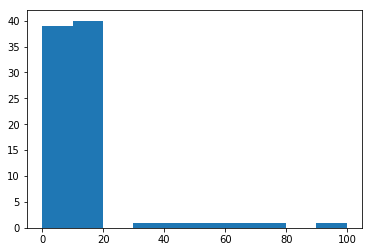

In [11]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(null_percent)


In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
columns_to_remove = [index for index in null_percent.index if null_percent[index] > 20]
print(columns_to_remove)
columns_with_no_missing_data = [index for index in null_percent.index if null_percent[index] == 0]
print(columns_with_no_missing_data)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP']


In [13]:
azdias = azdias.drop(columns_to_remove, axis=1)
feat_info = feat_info[~feat_info['attribute'].isin(columns_to_remove)]

#### Discussion 1.1.2: Assess Missing Data in Each Column

The vast majority of columns contained less than 20% null values and as such it was decided that any columns with over 20% null values could be safely removed from the study without having a major impact on the range of data included. This included some columns with over 50% of missing values which meant that filling the NaNs with a measure of average would render potentially very biased and useless data.
Columns that were removed from the dataset were:
- AGER_TYP
- GEBURTSJAHR
- TITEL_KZ
- ALTER_HH
- KK_KUNDENTYP
- KBA05_BAUMAX

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

(array([  6.66873000e+05,   3.02360000e+04,   5.00000000e+04,
          2.76340000e+04,   7.30300000e+03,   5.49800000e+03,
          7.92500000e+03,   1.60800000e+03,   6.28000000e+02,
          2.01000000e+02,   1.14000000e+02,   4.10000000e+01,
          9.00000000e+00,   1.40070000e+04,   3.99500000e+03,
          1.03600000e+03,   4.93000000e+02,   2.75450000e+04,
          4.94000000e+02,   4.55810000e+04]),
 array([  0.  ,   2.45,   4.9 ,   7.35,   9.8 ,  12.25,  14.7 ,  17.15,
         19.6 ,  22.05,  24.5 ,  26.95,  29.4 ,  31.85,  34.3 ,  36.75,
         39.2 ,  41.65,  44.1 ,  46.55,  49.  ]),
 <a list of 20 Patch objects>)

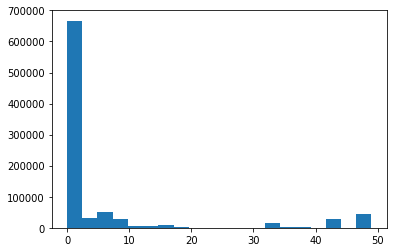

In [14]:
# How much data is missing in each row of the dataset?
null_rows = azdias.isnull().sum(axis=1)
plt.hist(null_rows, bins=20)

In [15]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
high_nulls = azdias.loc[null_rows >= 30]
low_nulls = azdias.loc[null_rows < 30]
print(len(high_nulls))
print(len(low_nulls))

93160
798061


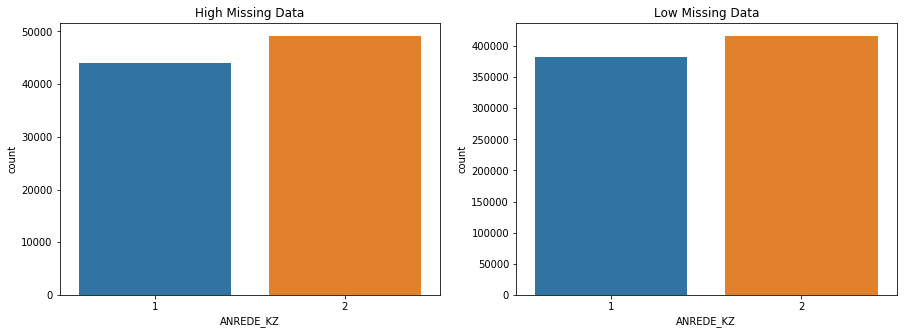

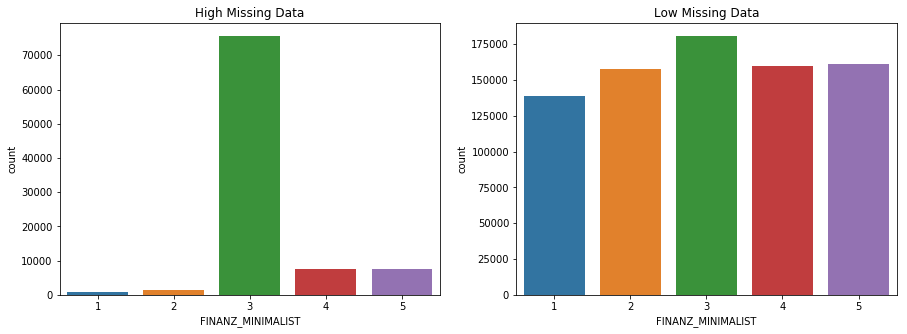

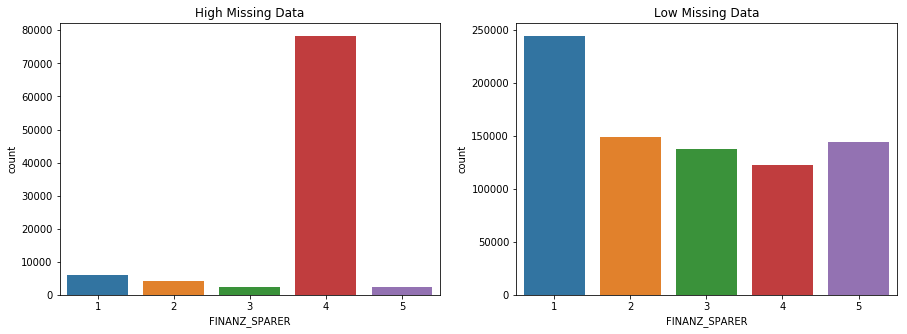

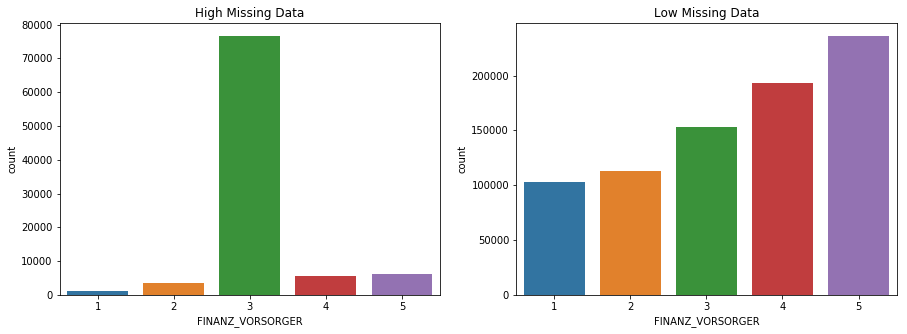

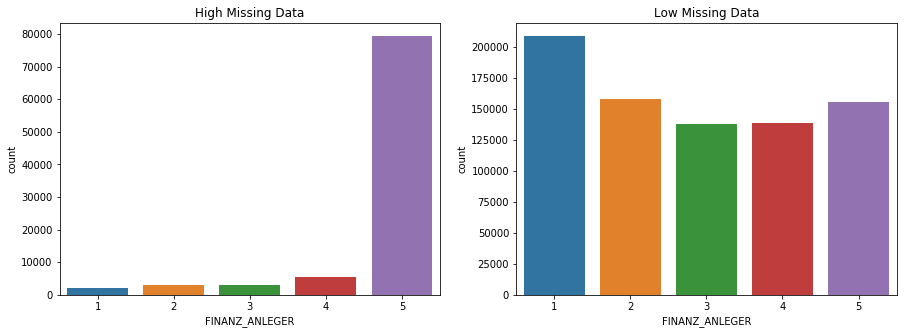

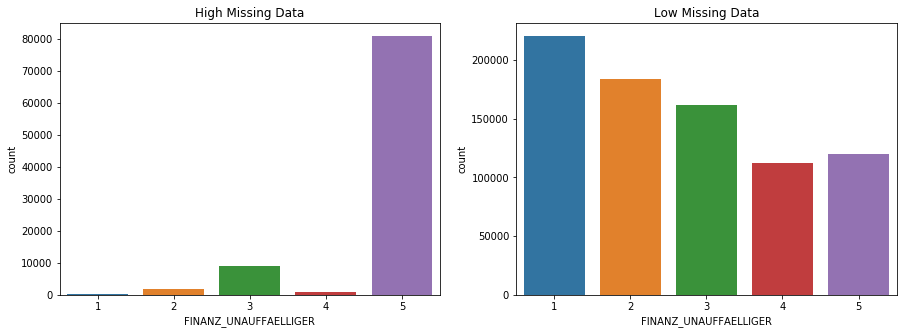

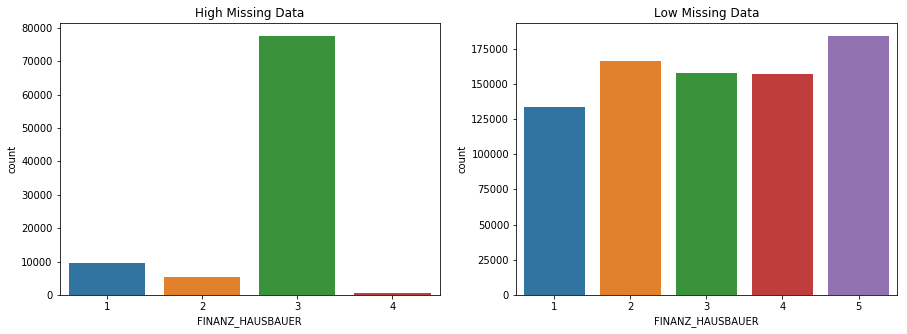

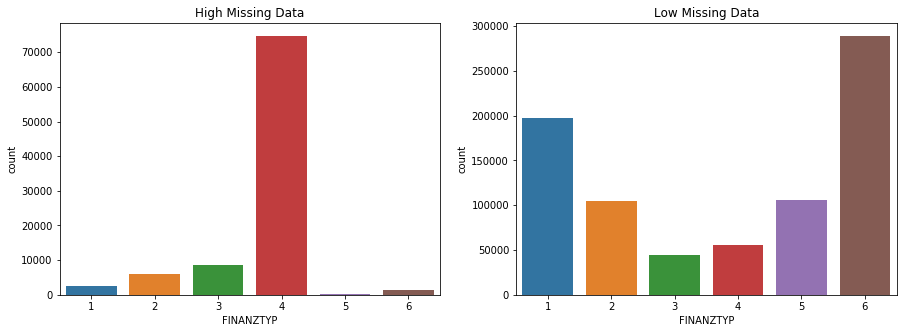

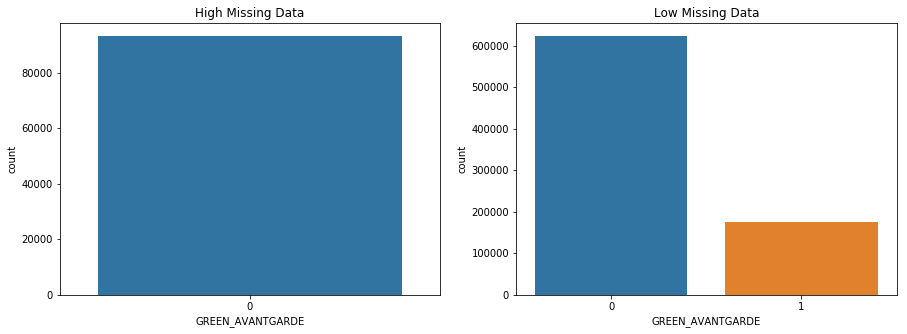

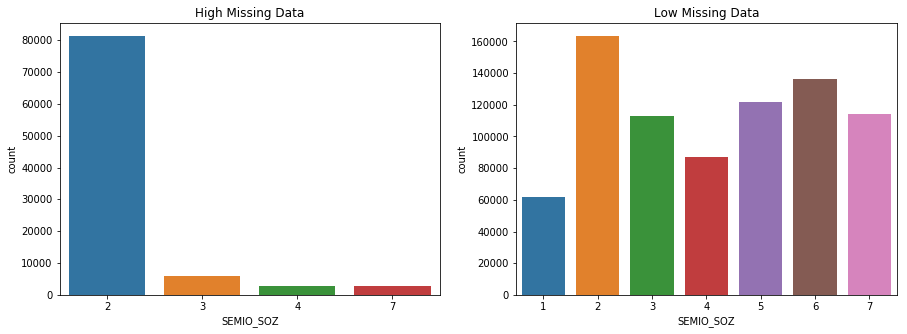

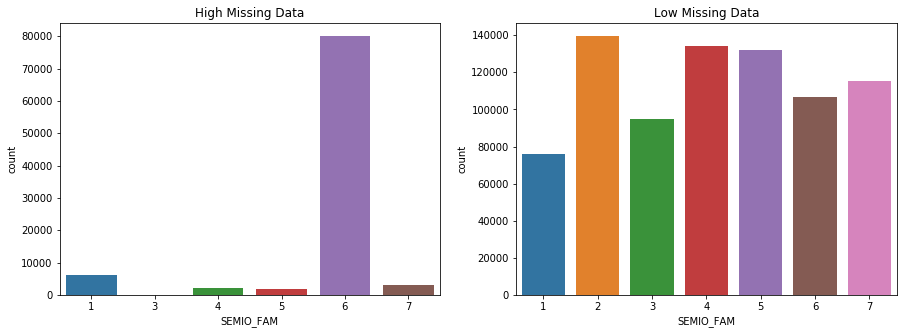

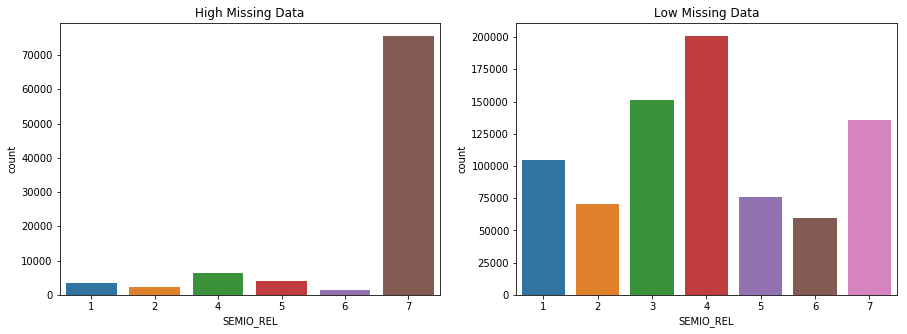

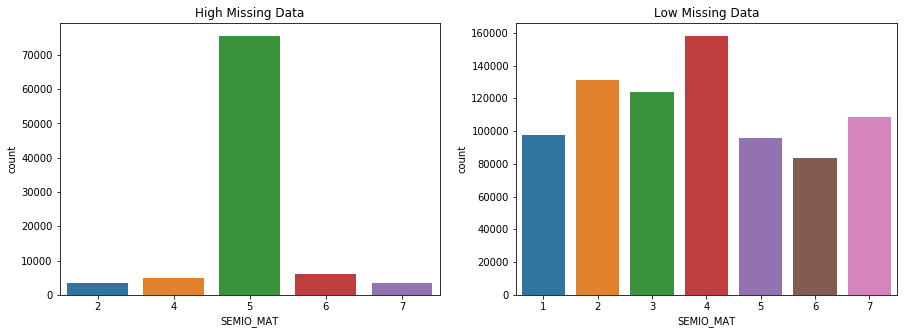

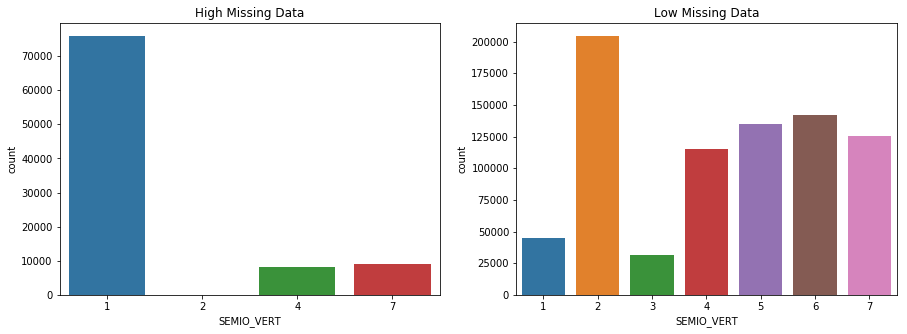

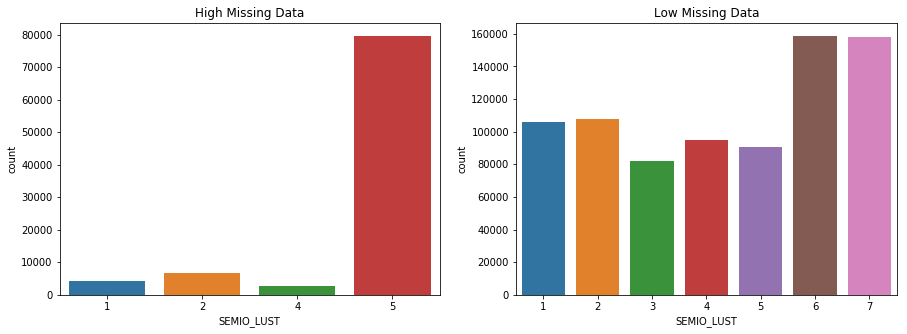

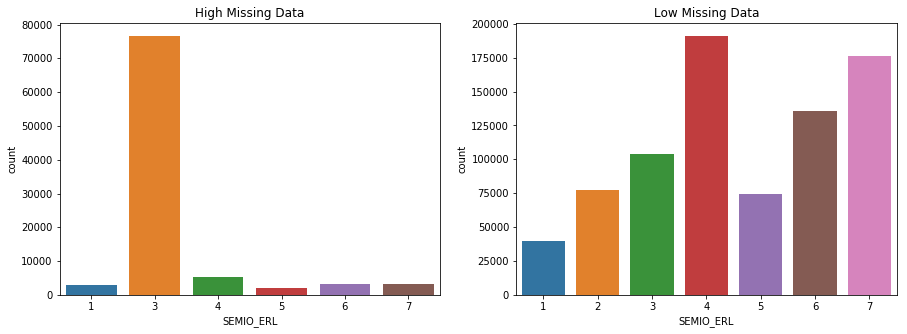

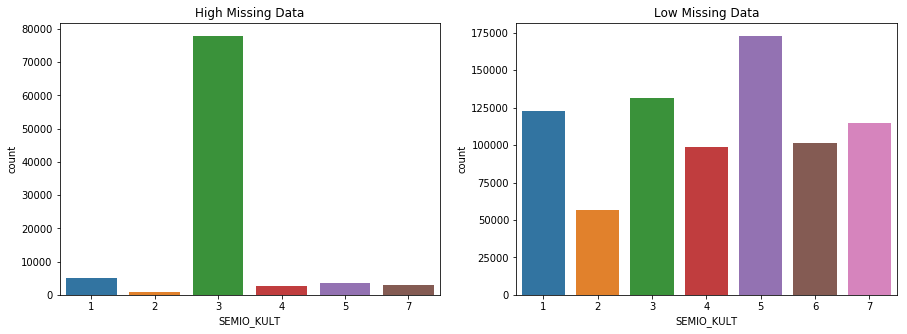

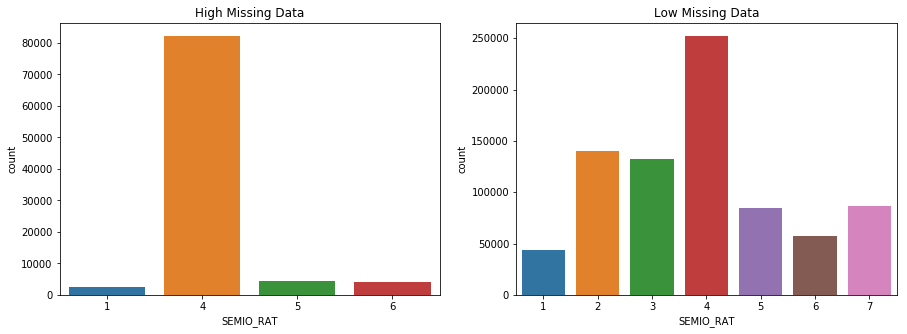

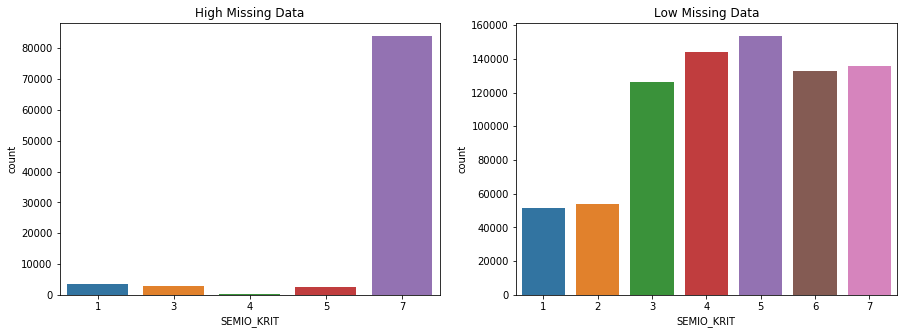

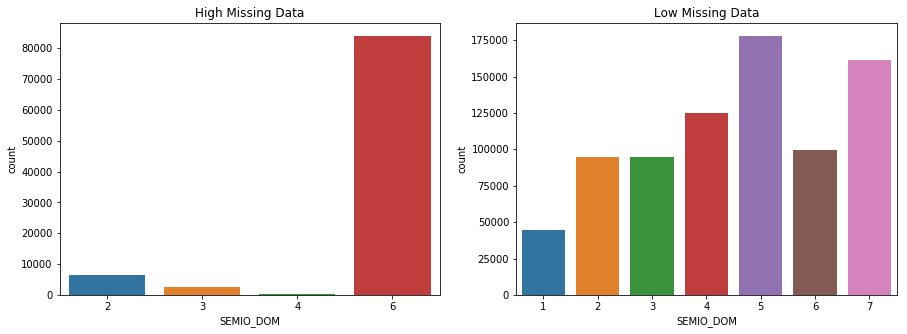

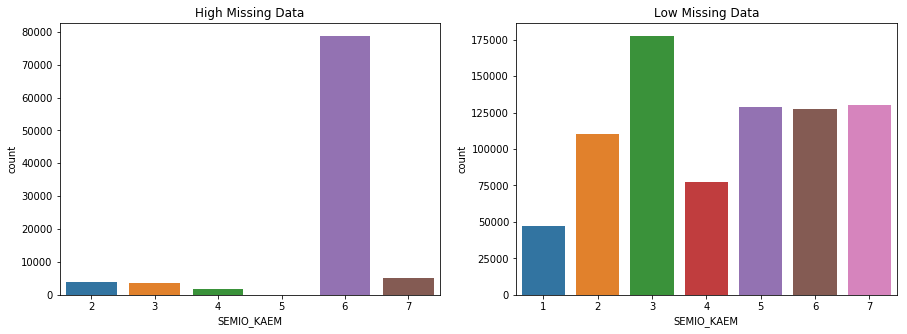

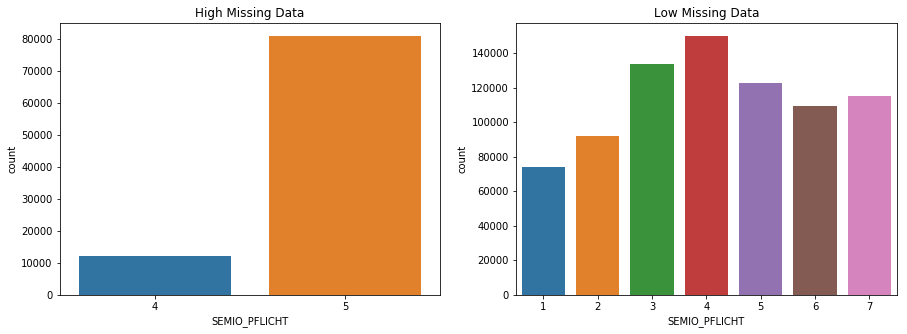

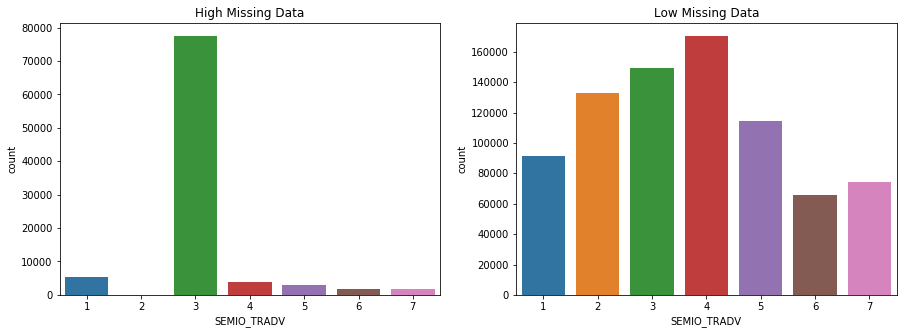

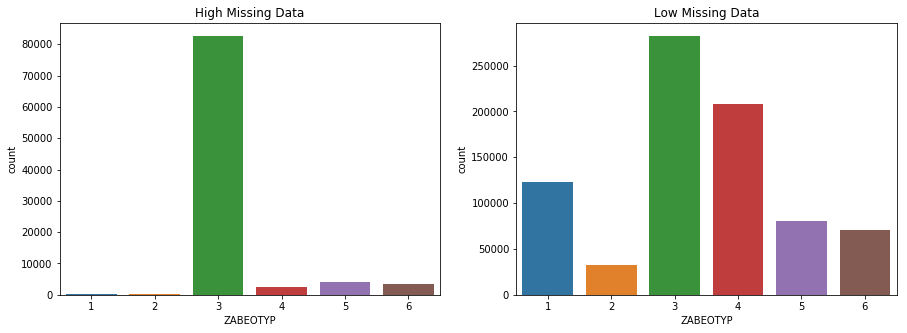

In [16]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
for column in columns_with_no_missing_data:
    fig = plt.figure(1, figsize=(15,5))

    ax1 = fig.add_subplot(121)
    sns.countplot(high_nulls[column])
    ax1.title.set_text('High Missing Data')

    ax2 = fig.add_subplot(122)
    sns.countplot(low_nulls[column])
    ax2.title.set_text('Low Missing Data')

    plt.show()


In [17]:
# this code has been moved to later in the process as adding medians to string columns was causing problems
# medians = low_nulls.copy(deep=True).median().iloc[0]
# azdias = low_nulls.fillna(medians).copy(deep=True)
azdias = low_nulls.copy(deep=True)

In [18]:
null_percent = azdias.isna().sum()/len(azdias)*100
null_percent.sort_values()

ZABEOTYP                 0.000000
ANZ_TITEL                0.000000
SEMIO_SOZ                0.000000
SEMIO_FAM                0.000000
SEMIO_REL                0.000000
SEMIO_MAT                0.000000
SEMIO_VERT               0.000000
SEMIO_LUST               0.000000
SEMIO_ERL                0.000000
SEMIO_KULT               0.000000
SEMIO_RAT                0.000000
SEMIO_KRIT               0.000000
SEMIO_DOM                0.000000
SEMIO_KAEM               0.000000
SEMIO_PFLICHT            0.000000
SEMIO_TRADV              0.000000
HH_EINKOMMEN_SCORE       0.000000
WOHNDAUER_2008           0.000000
GEBAEUDETYP              0.000000
FINANZ_HAUSBAUER         0.000000
ANREDE_KZ                0.000000
FINANZ_MINIMALIST        0.000000
FINANZ_SPARER            0.000000
FINANZ_VORSORGER         0.000000
FINANZ_ANLEGER           0.000000
FINANZ_UNAUFFAELLIGER    0.000000
ANZ_PERSONEN             0.000000
SOHO_KZ                  0.000000
GREEN_AVANTGARDE         0.000000
WOHNLAGE      

In [19]:
azdias.isna().sum().sum()

1014187

#### Discussion 1.1.3: Assess Missing Data in Each Row

The investigation showed that there was a relative split between two sections of data. The first group was rows with under 30% missing values, which accounted for the vast majority of the data, and a second group with over 30% missing values. When the two groups are plotted against eachother for features that have all entries present it is very clear that the rows represent very different groupings in the data. Due to this it would not be appropriate to fill the nans in the 'high nan' rows with a measure of average as the average would not be truly representative of those rows. Due to this the decision is made to drop the 'high nan' rows from the study completely and replace nans in remaining rows with an approporiate measure of average in a later stage.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [20]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [21]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_columns = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()
unique_values = {column:azdias[column].unique() for column in categorical_columns}
multi_categories = []
numeric_binary = []
non_numeric_binary = []
for column in categorical_columns:
    if len(azdias[column].unique()) > 2:
        multi_categories.append(column)
    elif type(azdias[column].unique()[0]) == str:
        non_numeric_binary.append(column)
    else:
        numeric_binary.append(column)
print(multi_categories)
print(numeric_binary)
print(non_numeric_binary)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ']
['OST_WEST_KZ']


In [22]:
# Re-encode categorical variable(s) to be kept in the analysis.
for column in non_numeric_binary:
    vals = azdias[column].unique()
    azdias[column] = azdias[column].map({vals[0]:0,vals[1]:1})
for column in multi_categories:
    azdias = pd.concat([azdias, pd.get_dummies(azdias[column], prefix=column)],axis=1)
    azdias.drop([column],axis=1, inplace=True)

In [23]:
null_percent = azdias.isna().sum()/len(azdias)*100
null_percent.sort_values()

LP_FAMILIE_FEIN_9.0      0.000000
SHOPPER_TYP_1.0          0.000000
SHOPPER_TYP_2.0          0.000000
SHOPPER_TYP_3.0          0.000000
VERS_TYP_1.0             0.000000
VERS_TYP_2.0             0.000000
ZABEOTYP_1               0.000000
ZABEOTYP_2               0.000000
ZABEOTYP_3               0.000000
ZABEOTYP_4               0.000000
SHOPPER_TYP_0.0          0.000000
ZABEOTYP_5               0.000000
GEBAEUDETYP_1.0          0.000000
GEBAEUDETYP_2.0          0.000000
GEBAEUDETYP_3.0          0.000000
GEBAEUDETYP_4.0          0.000000
GEBAEUDETYP_5.0          0.000000
GEBAEUDETYP_6.0          0.000000
GEBAEUDETYP_8.0          0.000000
CAMEO_DEUG_2015_1        0.000000
CAMEO_DEUG_2015_2        0.000000
ZABEOTYP_6               0.000000
NATIONALITAET_KZ_3.0     0.000000
NATIONALITAET_KZ_2.0     0.000000
NATIONALITAET_KZ_1.0     0.000000
LP_FAMILIE_FEIN_11.0     0.000000
LP_FAMILIE_GROB_1.0      0.000000
LP_FAMILIE_GROB_2.0      0.000000
LP_FAMILIE_GROB_3.0      0.000000
LP_FAMILIE_GRO

In [24]:
azdias.isna().sum().sum()

812515

#### Discussion 1.2.1: Re-Encode Categorical Features

After research it was decided that it was possible to effectively use all categorical features. Although it was unclear how useful they will be for the study it is better to leave decision to eliminate features up to PCA than to decide arbitrarily. The features were split into three categories:
- Numeric binary features
- Non numeric binary features
- Multi category features

Numeric binary features were left as they were.

Non numeric binary features were remapped to 0s and 1s.

Multi category features were split into multiple features using pandas's get dummies functionality.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

[ 14.  15.   8.   3.  10.  11.   5.   9.   6.   4.  nan   2.   1.  12.  13.
   7.]


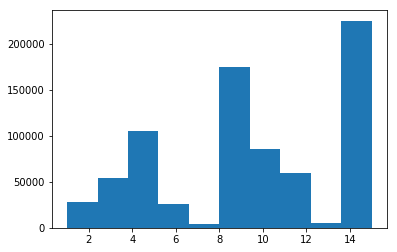

In [25]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
plt.hist(azdias['PRAEGENDE_JUGENDJAHRE'].dropna())
print(azdias['PRAEGENDE_JUGENDJAHRE'].unique())

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [26]:
decade_map = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
movement_map = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(movement_map)
azdias.drop(['PRAEGENDE_JUGENDJAHRE'],axis=1, inplace=True)

In [27]:
null_percent = azdias.isna().sum()/len(azdias)*100
null_percent.sort_values()

LP_FAMILIE_FEIN_10.0              0.000000
LP_STATUS_FEIN_2.0                0.000000
LP_STATUS_FEIN_3.0                0.000000
LP_STATUS_FEIN_4.0                0.000000
LP_STATUS_FEIN_5.0                0.000000
LP_STATUS_FEIN_6.0                0.000000
LP_STATUS_FEIN_7.0                0.000000
LP_STATUS_FEIN_8.0                0.000000
LP_STATUS_FEIN_1.0                0.000000
LP_STATUS_FEIN_9.0                0.000000
LP_STATUS_GROB_1.0                0.000000
LP_STATUS_GROB_2.0                0.000000
LP_STATUS_GROB_3.0                0.000000
LP_STATUS_GROB_4.0                0.000000
LP_STATUS_GROB_5.0                0.000000
NATIONALITAET_KZ_1.0              0.000000
NATIONALITAET_KZ_2.0              0.000000
LP_STATUS_FEIN_10.0               0.000000
LP_FAMILIE_GROB_5.0               0.000000
LP_FAMILIE_GROB_4.0               0.000000
LP_FAMILIE_GROB_3.0               0.000000
GFK_URLAUBERTYP_9.0               0.000000
GFK_URLAUBERTYP_10.0              0.000000
GFK_URLAUBE

841270

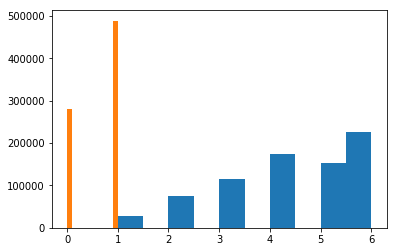

In [28]:
plt.hist(azdias['PRAEGENDE_JUGENDJAHRE_DECADE'].dropna())
plt.hist(azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].dropna())
azdias.isna().sum().sum()

['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' nan '25'
 '23' '31' '52' '35' '45' '44' '32']


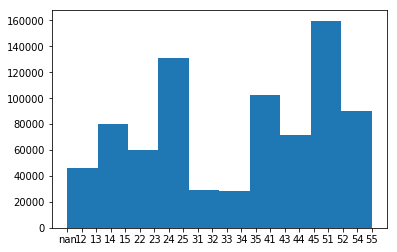

In [29]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
plt.hist(azdias['CAMEO_INTL_2015'])
print(azdias['CAMEO_INTL_2015'].unique())

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [30]:
wealth_map = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}
azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'].map(wealth_map)
life_stage_map = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}
azdias['CAMEO_INTL_2015_LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].map(life_stage_map)
azdias.drop(['CAMEO_INTL_2015'],axis=1, inplace=True)

In [31]:
null_percent = azdias.isna().sum()/len(azdias)*100
null_percent.sort_values()

LP_FAMILIE_GROB_1.0               0.000000
LP_STATUS_FEIN_3.0                0.000000
LP_STATUS_FEIN_4.0                0.000000
LP_STATUS_FEIN_5.0                0.000000
LP_STATUS_FEIN_6.0                0.000000
LP_STATUS_FEIN_7.0                0.000000
LP_STATUS_FEIN_8.0                0.000000
LP_STATUS_FEIN_9.0                0.000000
LP_STATUS_FEIN_2.0                0.000000
LP_STATUS_FEIN_10.0               0.000000
LP_STATUS_GROB_2.0                0.000000
LP_STATUS_GROB_3.0                0.000000
LP_STATUS_GROB_4.0                0.000000
LP_STATUS_GROB_5.0                0.000000
NATIONALITAET_KZ_1.0              0.000000
NATIONALITAET_KZ_2.0              0.000000
NATIONALITAET_KZ_3.0              0.000000
LP_STATUS_GROB_1.0                0.000000
LP_STATUS_FEIN_1.0                0.000000
LP_FAMILIE_GROB_5.0               0.000000
LP_FAMILIE_GROB_4.0               0.000000
GFK_URLAUBERTYP_10.0              0.000000
GFK_URLAUBERTYP_11.0              0.000000
GFK_URLAUBE

In [32]:
azdias.isna().sum().sum()

847468

#### Discussion 1.2.2: Engineer Mixed-Type Features

Similar to the feature engineering steps previously it was decided to keep all features at this stage and allow PCA to remove unneccesary features later on. Both of the mixed-type features contained two seperate features which were extracted by creating a map (based upon info obtained in the data dictionary) and then applied to the columns. At the end of this process the original features are removed from the df as they are no longer relevant.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [33]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
medians = azdias.copy(deep=True).median().iloc[0]
azdias = azdias.fillna(medians).copy(deep=True)
azdias.isna().sum().sum()

0

In [34]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [35]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame, feat_info DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    missing_value_dict = {row[1]['attribute']:string_to_int_if_number(row) for row in feat_info.iterrows()}
    for key in missing_value_dict:
        values = missing_value_dict[key]
        for value in values:
            df[key] = df[key].replace(value, np.NaN)
    # remove selected columns and rows, ...
    columns_to_remove = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(columns_to_remove, axis=1)
    feat_info = feat_info[~feat_info['attribute'].isin(columns_to_remove)]
    null_rows = df.isnull().sum(axis=1)
    df = df.loc[null_rows < 30]
    # select, re-encode, and engineer column values.
    categorical_columns = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()
    unique_values = {column:df[column].unique() for column in categorical_columns}
    multi_categories = []
    numeric_binary = []
    non_numeric_binary = []
    for column in categorical_columns:
        if len(df[column].unique()) > 2:
            multi_categories.append(column)
        elif type(df[column].unique()[0]) == str:
            non_numeric_binary.append(column)
        else:
            numeric_binary.append(column)
    for column in non_numeric_binary:
        vals = df[column].unique()
        df[column] = df[column].map({vals[0]:0,vals[1]:1})
    for column in multi_categories:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)],axis=1)
        df.drop([column],axis=1, inplace=True)
    decade_map = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
    movement_map = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_map)
    df.drop(['PRAEGENDE_JUGENDJAHRE'],axis=1, inplace=True)
    wealth_map = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].map(wealth_map)
    life_stage_map = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}
    df['CAMEO_INTL_2015_LIFE_STAGE'] = df['CAMEO_INTL_2015'].map(life_stage_map)
    df.drop(['CAMEO_INTL_2015'],axis=1, inplace=True)
    medians = df.copy(deep=True).median().iloc[0]
    df = df.fillna(medians).copy(deep=True)
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [36]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias.isna().sum().sum()


0

In [37]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
azdias_scaled = scalar.fit_transform(azdias)
azdias = pd.DataFrame(azdias_scaled, columns=list(azdias))
azdias.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,-1.766646,0.957914,-1.494594,1.537924,-1.040692,1.465965,0.958645,1.339314,-0.530409,1.010164,...,-0.150064,-0.162542,-0.189539,-0.179782,-0.192768,-0.089764,1.181576,0.433010,1.192567,-1.267054
1,0.200522,0.957914,-1.494594,0.864563,-1.766980,-0.570998,0.244119,1.339314,1.885336,1.010164,...,-0.150064,-0.162542,-0.189539,-0.179782,-0.192768,-0.089764,1.181576,-1.114218,-0.863668,0.761297
2,1.184106,0.957914,0.683144,-0.482158,1.138172,-0.570998,-1.184933,-0.791205,-0.530409,-0.311816,...,-0.150064,-0.162542,-0.189539,-0.179782,-0.192768,-0.089764,-0.195562,0.433010,-1.549079,-0.590937
3,0.200522,-1.043935,0.683144,0.191203,0.411884,-1.249985,0.244119,-0.791205,-0.530409,1.010164,...,-0.150064,-0.162542,-0.189539,-0.179782,-0.192768,-0.089764,-0.195562,0.433010,0.507156,0.085180
4,-1.766646,0.957914,-0.042768,-1.155518,1.138172,-0.570998,-0.470407,1.339314,-0.530409,1.010164,...,-0.150064,-0.162542,-0.189539,-0.179782,-0.192768,-0.089764,-1.572700,-1.114218,1.192567,0.761297
5,-0.783062,0.957914,-1.494594,1.537924,-1.766980,1.465965,0.958645,-0.081032,-0.530409,-0.311816,...,-0.150064,-0.162542,-0.189539,-0.179782,-0.192768,-0.089764,0.493007,0.433010,-0.863668,-0.590937
6,-1.766646,-1.043935,-0.042768,0.191203,0.411884,-1.249985,0.244119,-0.791205,-0.530409,-1.633796,...,-0.150064,-0.162542,-0.189539,-0.179782,-0.192768,-0.089764,-0.195562,0.433010,-1.549079,0.761297
7,0.200522,-1.043935,0.683144,0.864563,-1.040692,0.786978,-0.470407,-0.791205,1.885336,1.010164,...,-0.150064,-0.162542,-0.189539,-0.179782,-0.192768,-0.089764,0.493007,-1.114218,-1.549079,0.085180
8,0.200522,0.957914,-0.768681,0.864563,-1.040692,0.107990,1.673172,0.629141,1.885336,-0.311816,...,-0.150064,-0.162542,-0.189539,-0.179782,-0.192768,-0.089764,1.181576,-1.114218,-1.549079,1.437414
9,0.200522,0.957914,-0.768681,-0.482158,1.138172,0.107990,-1.184933,1.339314,-0.530409,-0.311816,...,-0.150064,-0.162542,-0.189539,-0.179782,5.187587,-0.089764,-1.572700,-1.114218,1.192567,-1.267054


### Discussion 2.1: Apply Feature Scaling

Feature scaling was carried out using sklearns standard scaler. There is no significant discussion to be had on this.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [38]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca_result_all_components = pca.fit(azdias)

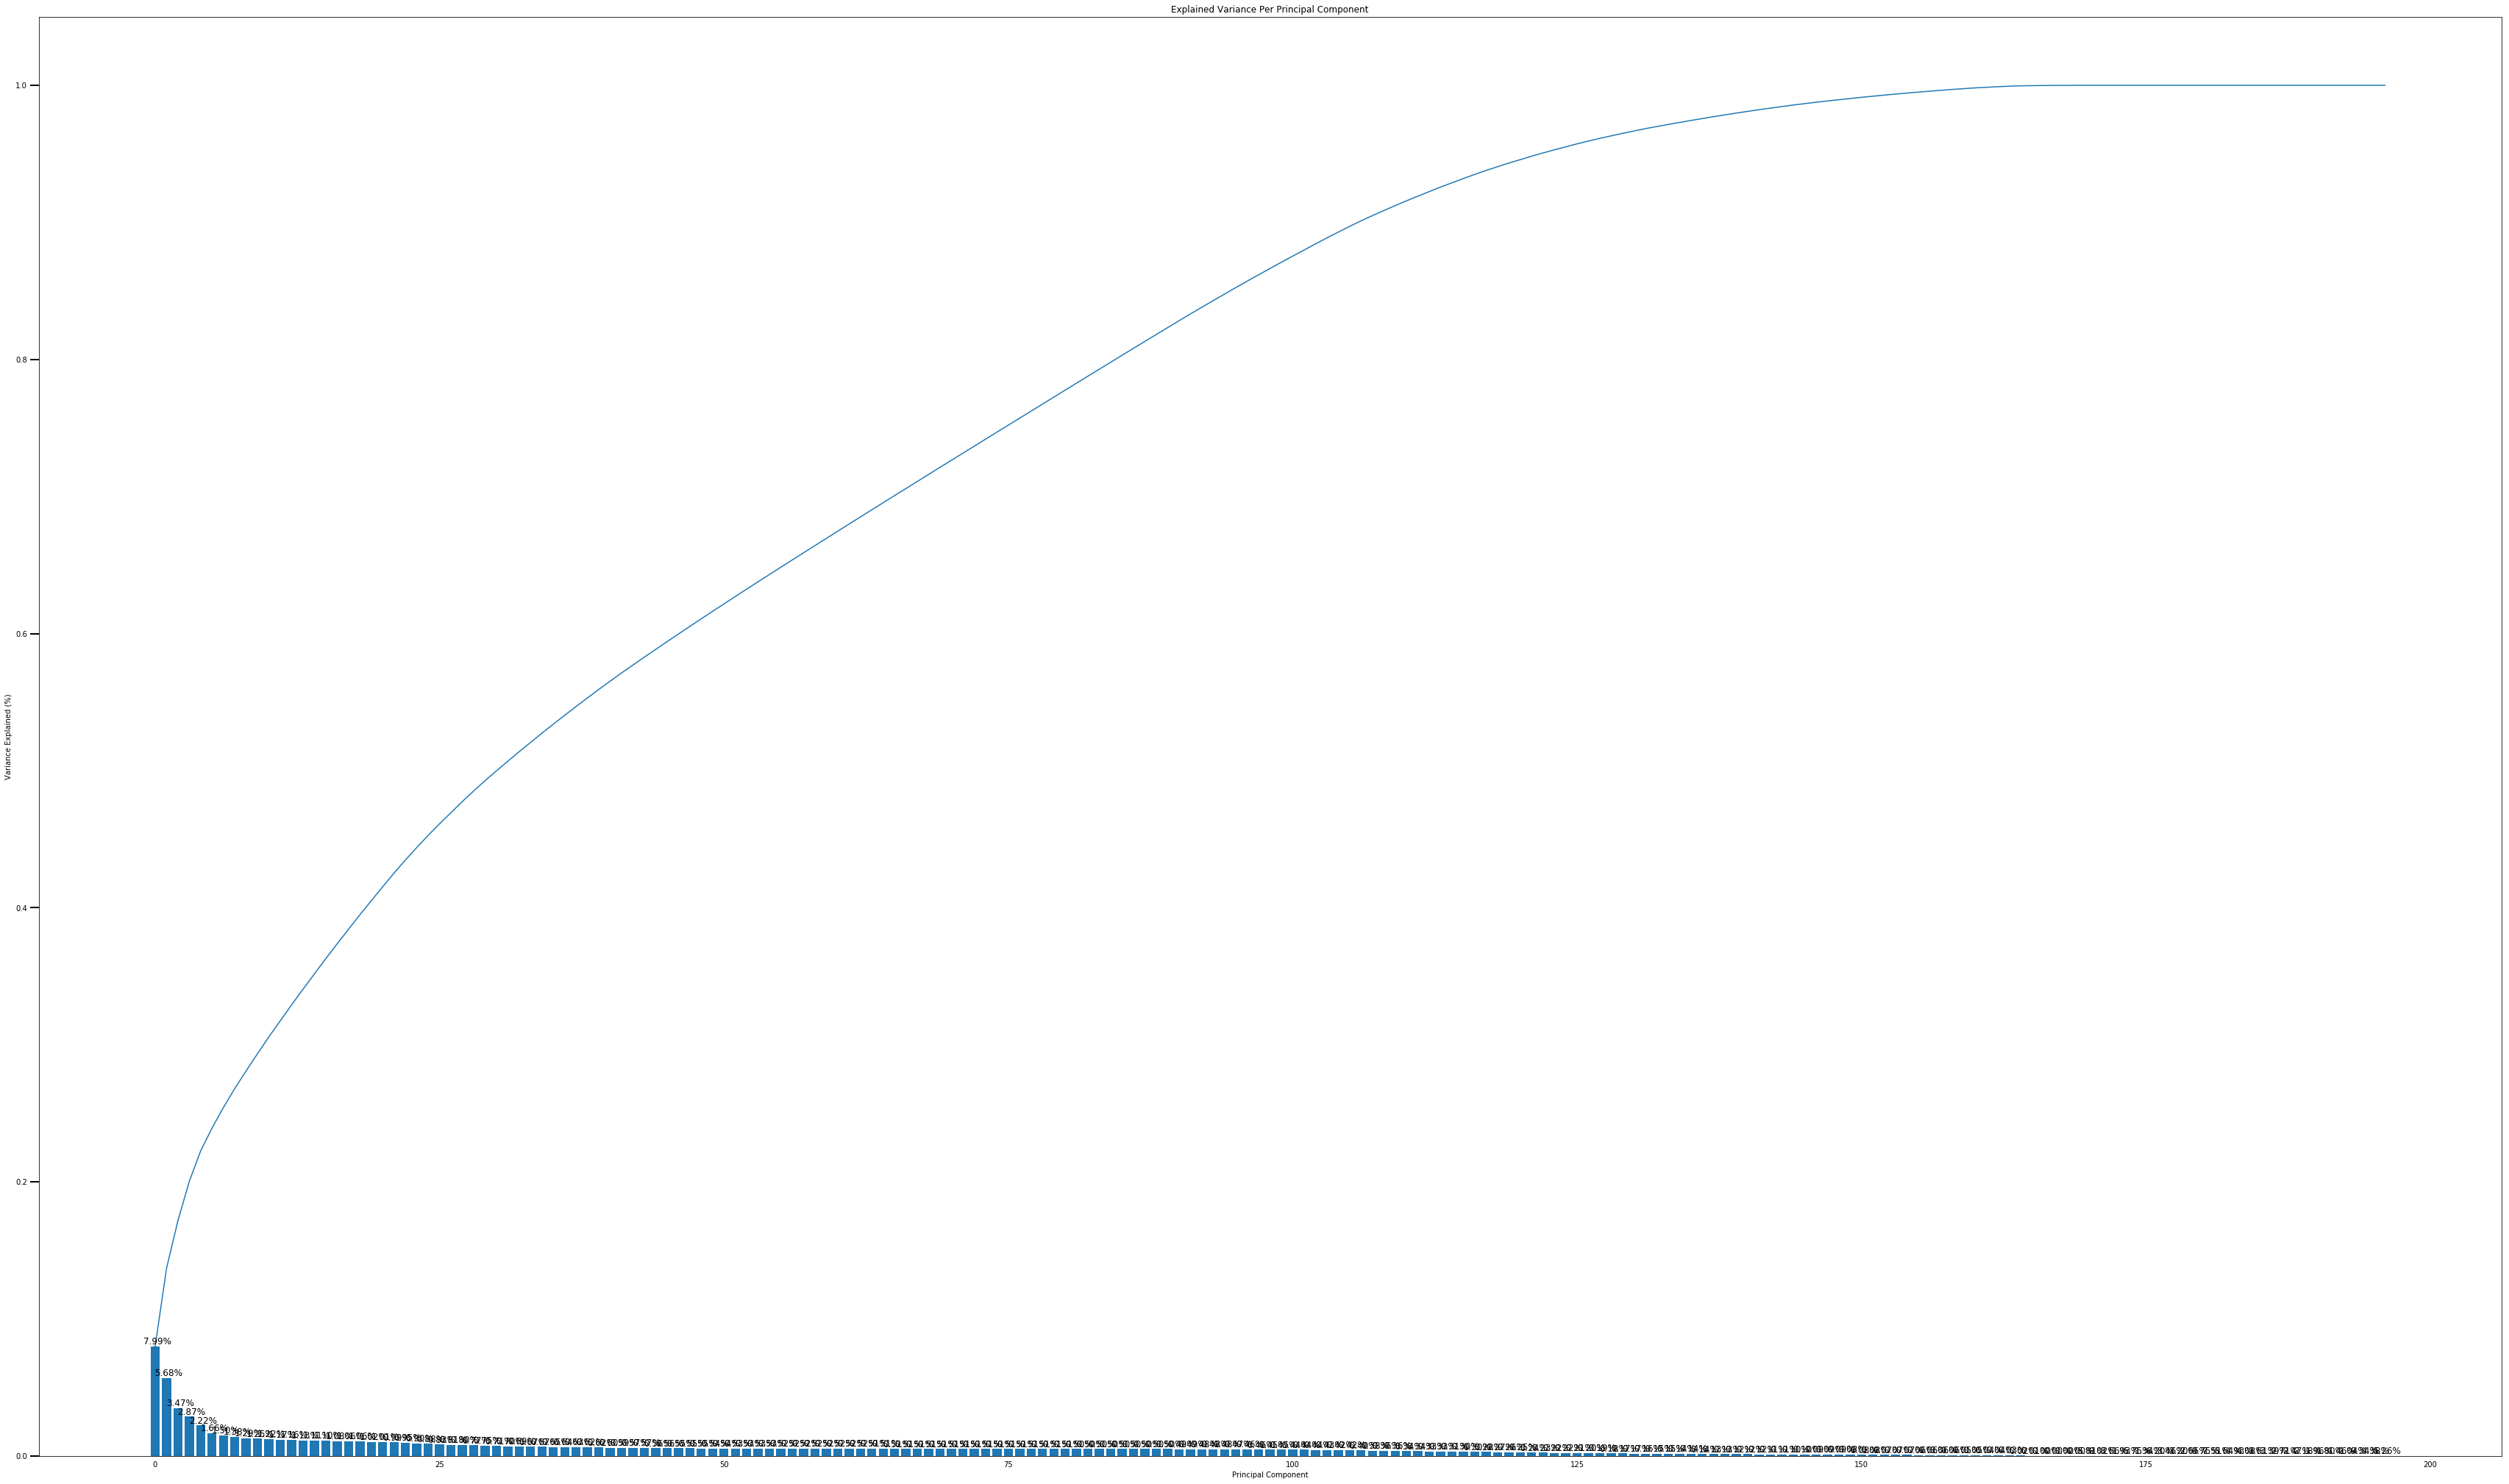

In [39]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(60, 36))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

scree_plot(pca)

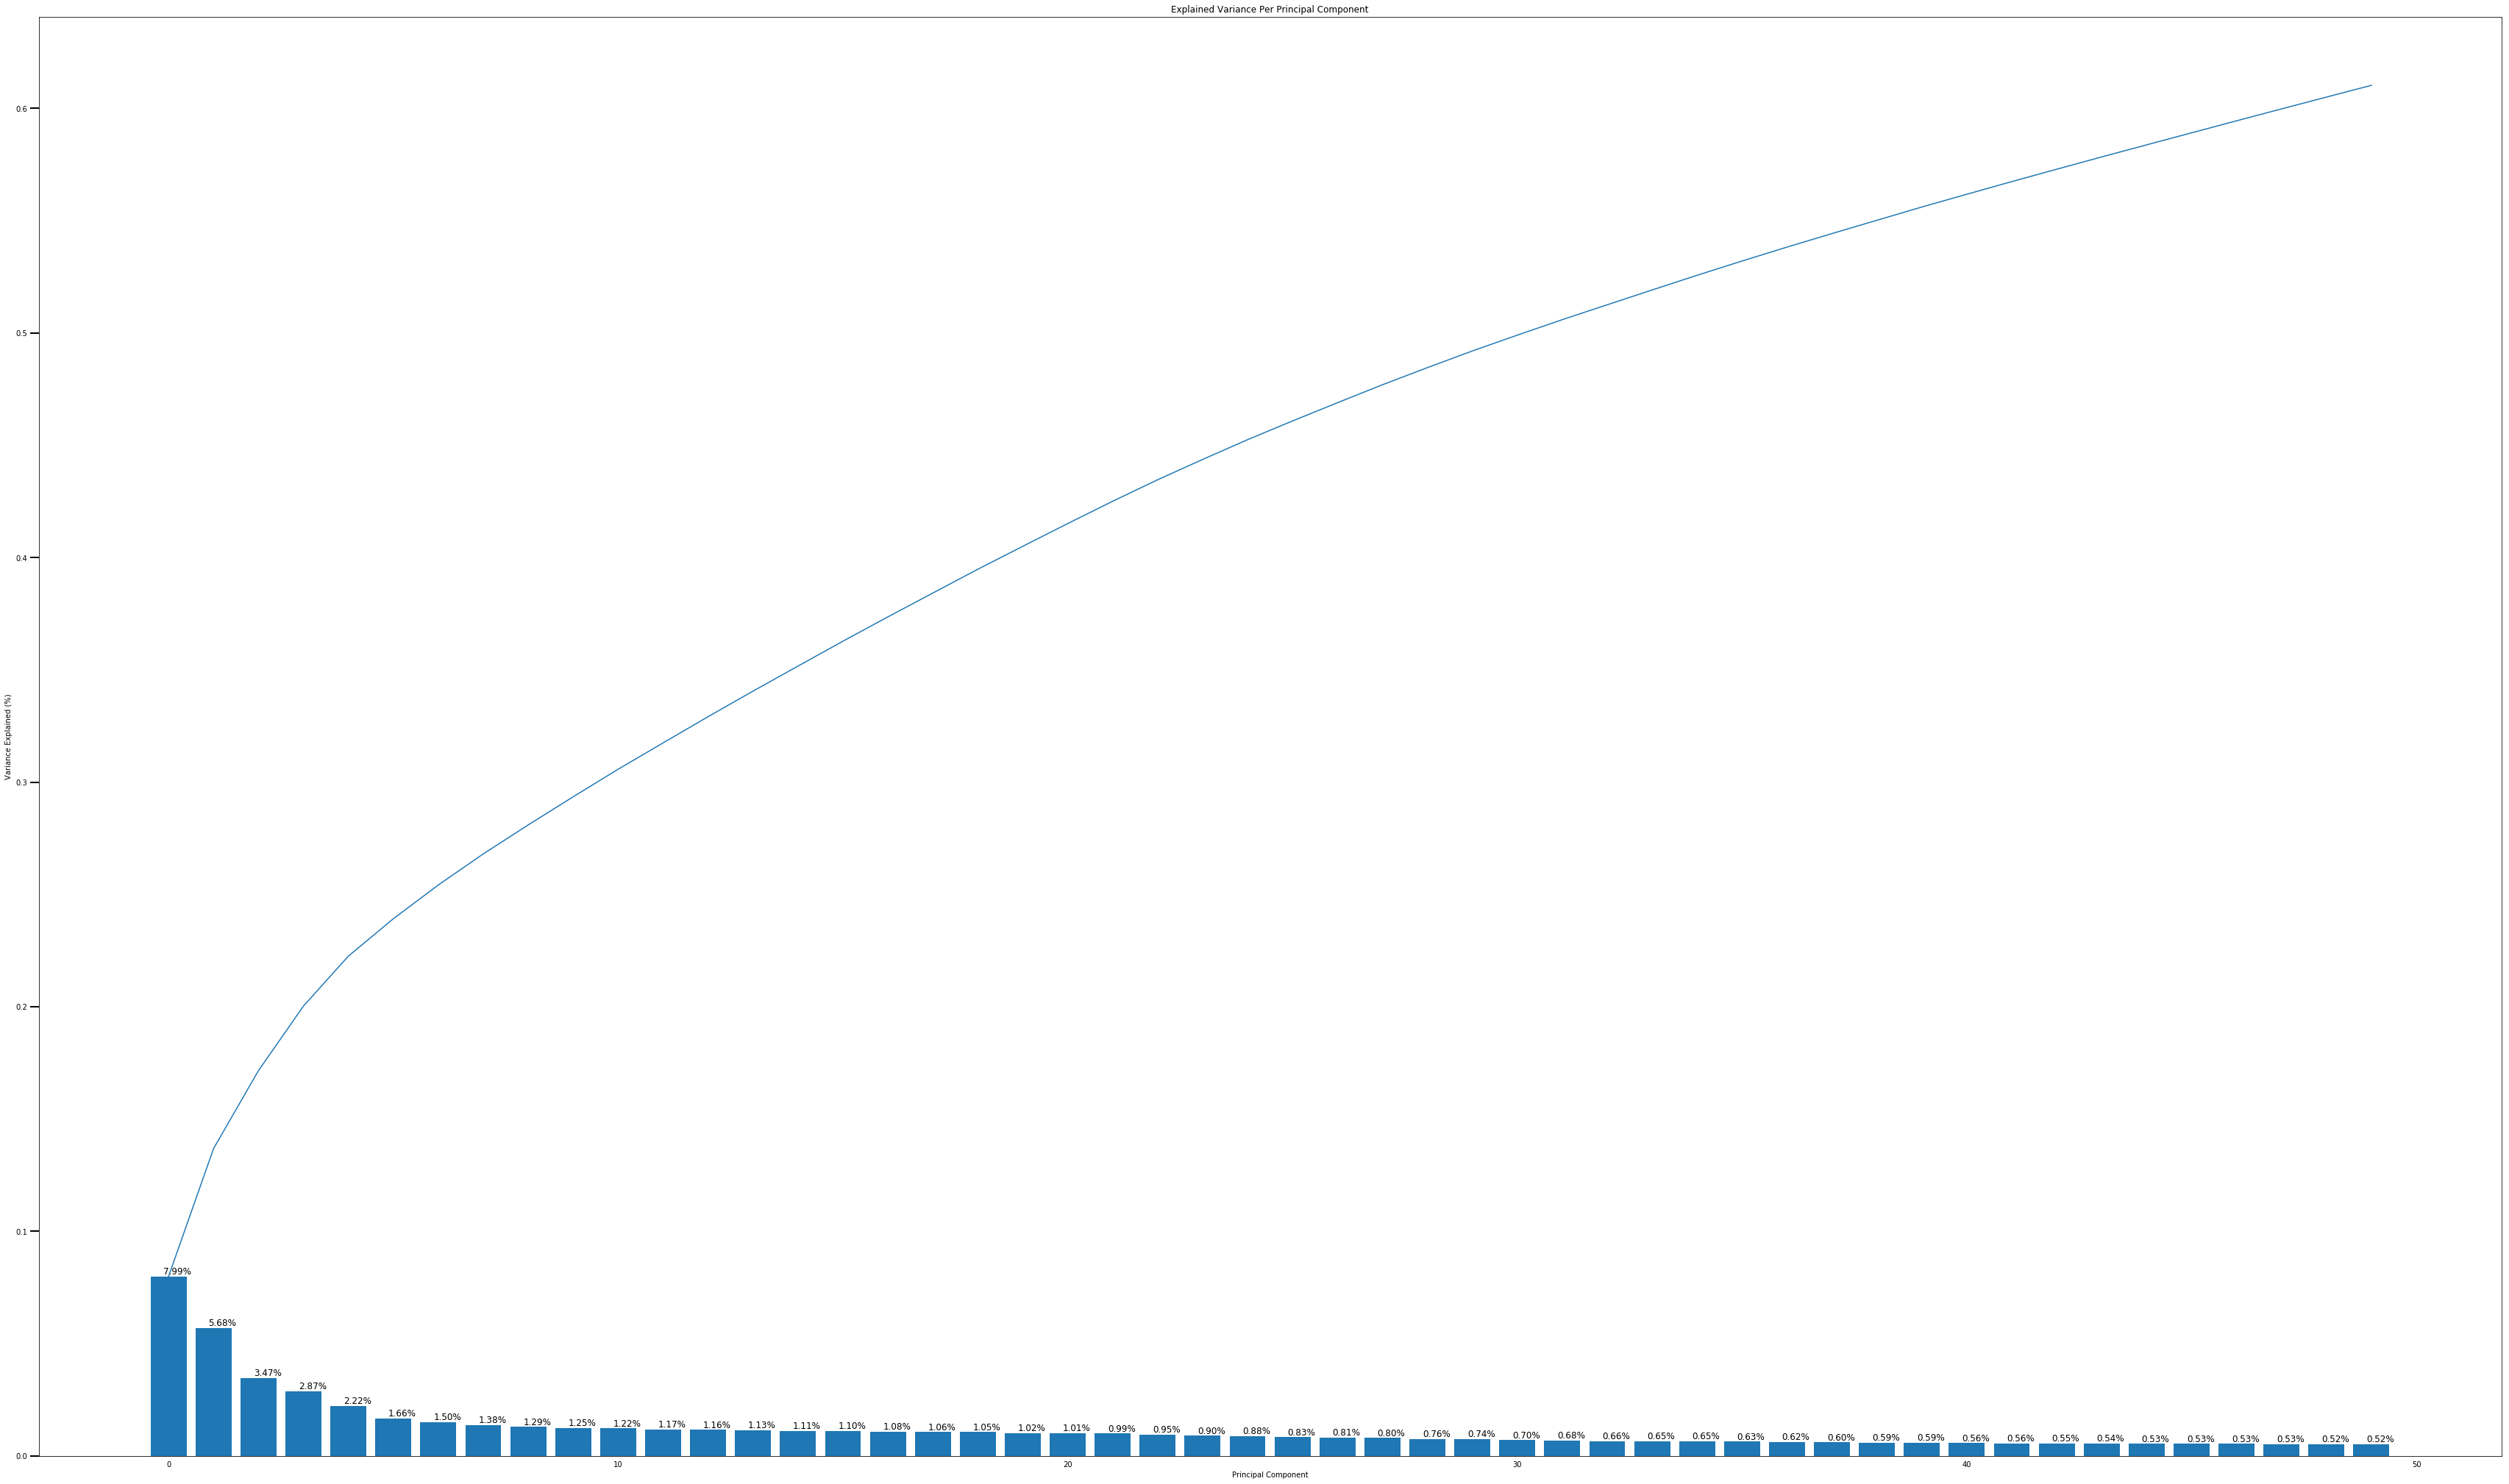

In [40]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=50)
azdias_columns = azdias.columns
azdias = pca.fit_transform(azdias)
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

Based upon principal component analysis it was decided to keep the first 50 out of 197 possible features. Assesing the scree plot it showed that over 60% of the vatiance was explained by these first 50 features and after this point the explained variance signficantly decreases per feature. Keeping any further features would have significantly increased the complexity and training time of the model but would have offered very little in terms of improving the quality of the clusters and the results.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [41]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def plot_components(X, y):
    '''
    plots the data in a 2 dimensional space to view separation
    INPUT: X - the x-matrix of input features
           y - the response column 
    OUTPUT: none
    '''
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure(figsize=(10, 6))
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]), color=plt.cm.Set1(y[i]), fontdict={'size': 15})

    plt.xticks([]), plt.yticks([]), plt.ylim([-0.1,1.1]), plt.xlim([-0.1,1.1])

pca_weights = pd.DataFrame(pca.components_, columns=azdias_columns.tolist())
    
#plot_components(pca, 0)
print(pca_weights.iloc[0].sort_values(ascending=False))

LP_STATUS_GROB_1.0                0.190368
CAMEO_INTL_2015_WEALTH            0.180578
HH_EINKOMMEN_SCORE                0.179738
PLZ8_ANTG3                        0.175774
PLZ8_BAUMAX                       0.169556
ORTSGR_KLS9                       0.155058
PLZ8_ANTG4                        0.154062
EWDICHTE                          0.153868
FINANZ_HAUSBAUER                  0.145441
PLZ8_ANTG2                        0.124808
LP_STATUS_FEIN_1.0                0.124573
ANZ_HAUSHALTE_AKTIV               0.112532
ARBEIT                            0.112335
LP_STATUS_FEIN_2.0                0.111535
CAMEO_DEUG_2015_9                 0.111231
FINANZ_SPARER                     0.109040
FINANZTYP_1                       0.108835
RELAT_AB                          0.106618
LP_FAMILIE_GROB_1.0               0.099408
LP_FAMILIE_FEIN_1.0               0.099408
CAMEO_DEUG_2015_8                 0.090271
KBA05_ANTG3                       0.087170
SEMIO_PFLICHT                     0.078576
SEMIO_REL  

In [42]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
#plot_components(pca, 1)
print(pca_weights.iloc[1].sort_values(ascending=False))

ALTERSKATEGORIE_GROB              0.233478
FINANZ_VORSORGER                  0.220141
ZABEOTYP_3                        0.198731
SEMIO_ERL                         0.178450
SEMIO_LUST                        0.163707
RETOURTYP_BK_S                    0.154797
W_KEIT_KIND_HH                    0.129408
CJT_GESAMTTYP_2.0                 0.109210
FINANZTYP_5                       0.098414
FINANZ_MINIMALIST                 0.094049
FINANZTYP_2                       0.093944
LP_STATUS_FEIN_1.0                0.091475
FINANZ_HAUSBAUER                  0.081426
SHOPPER_TYP_3.0                   0.073546
CJT_GESAMTTYP_1.0                 0.071370
SEMIO_KRIT                        0.071025
NATIONALITAET_KZ_1.0              0.069336
FINANZTYP_6                       0.067074
LP_FAMILIE_FEIN_1.0               0.063608
LP_FAMILIE_GROB_1.0               0.063608
EWDICHTE                          0.060101
ORTSGR_KLS9                       0.059121
GFK_URLAUBERTYP_4.0               0.058770
PLZ8_ANTG3 

In [43]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
#plot_components(pca, 2)
print(pca_weights.iloc[2].sort_values(ascending=False))

SEMIO_VERT                        0.320671
SEMIO_FAM                         0.261118
SEMIO_SOZ                         0.257645
SEMIO_KULT                        0.253268
FINANZTYP_5                       0.132192
FINANZ_MINIMALIST                 0.131597
SHOPPER_TYP_0.0                   0.124325
ZABEOTYP_1                        0.117570
SEMIO_REL                         0.113072
SEMIO_MAT                         0.089291
RETOURTYP_BK_S                    0.071864
GREEN_AVANTGARDE                  0.067602
W_KEIT_KIND_HH                    0.063463
ORTSGR_KLS9                       0.060575
EWDICHTE                          0.059860
SHOPPER_TYP_1.0                   0.055623
PLZ8_BAUMAX                       0.050885
ZABEOTYP_6                        0.048340
LP_STATUS_GROB_5.0                0.047528
LP_STATUS_FEIN_10.0               0.047528
PLZ8_ANTG3                        0.046603
FINANZ_VORSORGER                  0.045844
PLZ8_ANTG4                        0.043328
LP_STATUS_F

### Discussion 2.3: Interpret Principal Components

In the first principal component it can be seen that:
- There is a relatively strong positive correlation between features 'LP_STATUS_GROB_1.0' and 'CAMEO_INTL_2015_WEALTH'  showing that those in lower income brackets are more likely to be living in poor households which is exactly as expected.
- There is a relatively strong negative correlation between features 'KBA05_ANTG1' and 'MOBI_REGIO' showing that the higher the number of 1-2 households in the cell the mobility of those people is higher which is also as expected.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [44]:
import signal

from contextlib import contextmanager

import requests


DELAY = INTERVAL = 4 * 60  # interval time in seconds
MIN_DELAY = MIN_INTERVAL = 2 * 60
KEEPALIVE_URL = "https://nebula.udacity.com/api/v1/remote/keep-alive"
TOKEN_URL = "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token"
TOKEN_HEADERS = {"Metadata-Flavor":"Google"}


def _request_handler(headers):
    def _handler(signum, frame):
        requests.request("POST", KEEPALIVE_URL, headers=headers)
    return _handler


@contextmanager
def active_session(delay=DELAY, interval=INTERVAL):
    """
    Example:

    from workspace_utils import active session

    with active_session():
        # do long-running work here
    """
    token = requests.request("GET", TOKEN_URL, headers=TOKEN_HEADERS).text
    headers = {'Authorization': "STAR " + token}
    delay = max(delay, MIN_DELAY)
    interval = max(interval, MIN_INTERVAL)
    original_handler = signal.getsignal(signal.SIGALRM)
    try:
        signal.signal(signal.SIGALRM, _request_handler(headers))
        signal.setitimer(signal.ITIMER_REAL, delay, interval)
        yield
    finally:
        signal.signal(signal.SIGALRM, original_handler)
        signal.setitimer(signal.ITIMER_REAL, 0)


def keep_awake(iterable, delay=DELAY, interval=INTERVAL):
    """
    Example:

    from workspace_utils import keep_awake

    for i in keep_awake(range(5)):
        # do iteration with lots of work here
    """
    with active_session(delay, interval): yield from iterable

In [45]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans
results = []
for count in keep_awake(range(1, 20)):
    # run k-means clustering on the data and...
    model = KMeans(n_clusters = count)
    model = model.fit(azdias)
    # compute the average within-cluster distances.
    score = model.score(azdias)
    results.append(score)
    print('Number of clusters: {} Score: {}'.format(count, score))

Number of clusters: 1 Score: -95946383.13326126
Number of clusters: 2 Score: -86392811.06588176
Number of clusters: 3 Score: -81860079.05270775
Number of clusters: 4 Score: -78935999.65975097
Number of clusters: 5 Score: -76813912.77198021
Number of clusters: 6 Score: -75311311.58726469
Number of clusters: 7 Score: -73909317.27539772
Number of clusters: 8 Score: -72891843.30554321
Number of clusters: 9 Score: -71551757.16939035
Number of clusters: 10 Score: -70626219.55452709
Number of clusters: 11 Score: -69792628.48374179
Number of clusters: 12 Score: -68818907.23795997
Number of clusters: 13 Score: -68217220.79674307
Number of clusters: 14 Score: -67539500.89538911
Number of clusters: 15 Score: -66756931.101374
Number of clusters: 16 Score: -66229436.06072277
Number of clusters: 17 Score: -65695431.5685703
Number of clusters: 18 Score: -65206141.93154462
Number of clusters: 19 Score: -64170797.13997706


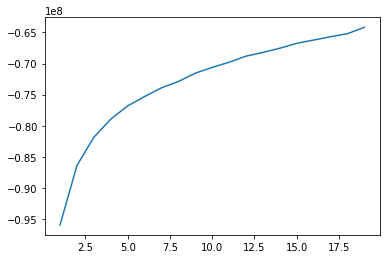

In [46]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(list(range(1, 20)), results)

In [47]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
model = KMeans(n_clusters = 12)
model = model.fit(azdias)
train_pred = model.predict(azdias)

### Discussion 3.1: Apply Clustering to General Population

It was decided to use 12 clusters as when plotting the results of the models trained on differnet numbers of clusters it shows that the incremental changes become very consistent after this point showing that any extra clusters will not add much more value to the model.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [48]:
# Load in the customer demographics data.
customers =  pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')

In [49]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')
customers = clean_data(customers, feat_info)
# adding column due to lack of 5 value in customers 'GEBAEUDETYP' column but need to match all azdias columns.
customers['GEBAEUDETYP_5.0'] = 0
customers_columns = customers.columns
customers.isna().sum().sum()

0

In [50]:
customers_scaled = scalar.transform(customers)
customers = pd.DataFrame(customers_scaled, columns=list(customers))
customers = pca.transform(customers)
customer_pred = model.predict(customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

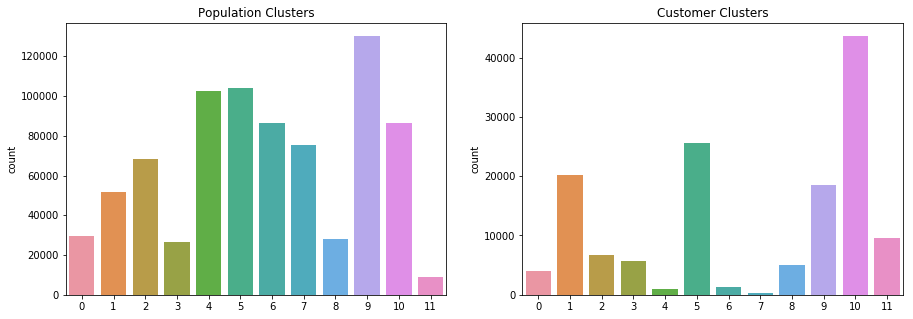

In [54]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig = plt.figure(1, figsize=(15,5))

ax1 = fig.add_subplot(121)
sns.countplot(train_pred)
ax1.title.set_text('Population Clusters')

ax2 = fig.add_subplot(122)
sns.countplot(customer_pred)
ax2.title.set_text('Customer Clusters')

plt.show()


In [52]:
cluster_0 = scalar.inverse_transform(pca.inverse_transform(model.cluster_centers_[0]))
cluster_0_dataframe = pd.Series(data=cluster_0, index=customers_columns)
print(cluster_0_dataframe)

ALTERSKATEGORIE_GROB               2.970293
ANREDE_KZ                          1.519971
FINANZ_MINIMALIST                  3.987806
FINANZ_SPARER                      2.131291
FINANZ_VORSORGER                   3.754810
FINANZ_ANLEGER                     2.255050
FINANZ_UNAUFFAELLIGER              2.577313
FINANZ_HAUSBAUER                   2.425294
GREEN_AVANTGARDE                   0.643596
HEALTH_TYP                         2.150446
LP_LEBENSPHASE_FEIN               20.758699
LP_LEBENSPHASE_GROB                6.153958
RETOURTYP_BK_S                     3.598270
SEMIO_SOZ                          4.178724
SEMIO_FAM                          3.737886
SEMIO_REL                          3.556120
SEMIO_MAT                          3.616073
SEMIO_VERT                         4.502894
SEMIO_LUST                         4.863175
SEMIO_ERL                          4.732205
SEMIO_KULT                         3.762453
SEMIO_RAT                          3.675159
SEMIO_KRIT                      

In [55]:
cluster_1 = scalar.inverse_transform(pca.inverse_transform(model.cluster_centers_[1]))
cluster_1_dataframe = pd.Series(data=cluster_1, index=customers_columns)
print(cluster_1_dataframe)

ALTERSKATEGORIE_GROB               3.282456
ANREDE_KZ                          1.381030
FINANZ_MINIMALIST                  3.403768
FINANZ_SPARER                      1.595572
FINANZ_VORSORGER                   4.430937
FINANZ_ANLEGER                     1.286379
FINANZ_UNAUFFAELLIGER              1.982082
FINANZ_HAUSBAUER                   3.837372
GREEN_AVANTGARDE                   0.391224
HEALTH_TYP                         2.155214
LP_LEBENSPHASE_FEIN               13.227820
LP_LEBENSPHASE_GROB                3.787578
RETOURTYP_BK_S                     4.256400
SEMIO_SOZ                          4.310541
SEMIO_FAM                          4.153291
SEMIO_REL                          3.340848
SEMIO_MAT                          3.824151
SEMIO_VERT                         4.908434
SEMIO_LUST                         5.282747
SEMIO_ERL                          4.823906
SEMIO_KULT                         3.859756
SEMIO_RAT                          3.105198
SEMIO_KRIT                      

In [56]:
cluster_2 = scalar.inverse_transform(pca.inverse_transform(model.cluster_centers_[2]))
cluster_2_dataframe = pd.Series(data=cluster_2, index=customers_columns)
print(cluster_2_dataframe)

ALTERSKATEGORIE_GROB               3.450995
ANREDE_KZ                          1.748370
FINANZ_MINIMALIST                  2.971470
FINANZ_SPARER                      1.923112
FINANZ_VORSORGER                   4.175657
FINANZ_ANLEGER                     2.722923
FINANZ_UNAUFFAELLIGER              1.806995
FINANZ_HAUSBAUER                   3.808344
GREEN_AVANTGARDE                   0.082708
HEALTH_TYP                         2.148674
LP_LEBENSPHASE_FEIN               11.430370
LP_LEBENSPHASE_GROB                3.404665
RETOURTYP_BK_S                     3.868925
SEMIO_SOZ                          3.215995
SEMIO_FAM                          2.899859
SEMIO_REL                          2.584492
SEMIO_MAT                          3.089939
SEMIO_VERT                         3.556228
SEMIO_LUST                         5.100638
SEMIO_ERL                          5.963385
SEMIO_KULT                         2.695153
SEMIO_RAT                          3.283763
SEMIO_KRIT                      

In [57]:
cluster_3 = scalar.inverse_transform(pca.inverse_transform(model.cluster_centers_[3]))
cluster_3_dataframe = pd.Series(data=cluster_3, index=customers_columns)
print(cluster_3_dataframe)

ALTERSKATEGORIE_GROB               2.939401
ANREDE_KZ                          1.415986
FINANZ_MINIMALIST                  3.804562
FINANZ_SPARER                      2.323572
FINANZ_VORSORGER                   3.595552
FINANZ_ANLEGER                     2.720631
FINANZ_UNAUFFAELLIGER              2.437573
FINANZ_HAUSBAUER                   2.539224
GREEN_AVANTGARDE                   0.391954
HEALTH_TYP                         2.262606
LP_LEBENSPHASE_FEIN               23.390192
LP_LEBENSPHASE_GROB                7.585232
RETOURTYP_BK_S                     3.398868
SEMIO_SOZ                          4.184916
SEMIO_FAM                          4.208737
SEMIO_REL                          3.898107
SEMIO_MAT                          3.874136
SEMIO_VERT                         4.795697
SEMIO_LUST                         4.594839
SEMIO_ERL                          4.607379
SEMIO_KULT                         4.310430
SEMIO_RAT                          3.702522
SEMIO_KRIT                      

In [58]:
cluster_4 = scalar.inverse_transform(pca.inverse_transform(model.cluster_centers_[4]))
cluster_4_dataframe = pd.Series(data=cluster_4, index=customers_columns)
print(cluster_4_dataframe)

ALTERSKATEGORIE_GROB              1.832679
ANREDE_KZ                         1.984905
FINANZ_MINIMALIST                 1.123047
FINANZ_SPARER                     4.448336
FINANZ_VORSORGER                  2.229944
FINANZ_ANLEGER                    4.375238
FINANZ_UNAUFFAELLIGER             3.831192
FINANZ_HAUSBAUER                  4.275804
GREEN_AVANTGARDE                  0.026737
HEALTH_TYP                        2.391532
LP_LEBENSPHASE_FEIN               9.000940
LP_LEBENSPHASE_GROB               3.314087
RETOURTYP_BK_S                    2.597307
SEMIO_SOZ                         3.236999
SEMIO_FAM                         3.879984
SEMIO_REL                         5.290229
SEMIO_MAT                         4.595639
SEMIO_VERT                        2.265609
SEMIO_LUST                        3.248263
SEMIO_ERL                         4.423439
SEMIO_KULT                        4.012101
SEMIO_RAT                         5.874789
SEMIO_KRIT                        5.456291
SEMIO_DOM  

In [59]:
cluster_5 = scalar.inverse_transform(pca.inverse_transform(model.cluster_centers_[5]))
cluster_5_dataframe = pd.Series(data=cluster_5, index=customers_columns)
print(cluster_5_dataframe)

ALTERSKATEGORIE_GROB               3.309358
ANREDE_KZ                          1.436413
FINANZ_MINIMALIST                  4.576957
FINANZ_SPARER                      1.708840
FINANZ_VORSORGER                   4.163853
FINANZ_ANLEGER                     2.476631
FINANZ_UNAUFFAELLIGER              1.811889
FINANZ_HAUSBAUER                   2.084021
GREEN_AVANTGARDE                  -0.000974
HEALTH_TYP                         2.201999
LP_LEBENSPHASE_FEIN               21.440238
LP_LEBENSPHASE_GROB                6.490330
RETOURTYP_BK_S                     3.579529
SEMIO_SOZ                          3.887412
SEMIO_FAM                          3.699493
SEMIO_REL                          3.283393
SEMIO_MAT                          3.141285
SEMIO_VERT                         4.635395
SEMIO_LUST                         4.895606
SEMIO_ERL                          5.093942
SEMIO_KULT                         3.891292
SEMIO_RAT                          3.183408
SEMIO_KRIT                      

In [60]:
cluster_6 = scalar.inverse_transform(pca.inverse_transform(model.cluster_centers_[6]))
cluster_6_dataframe = pd.Series(data=cluster_6, index=customers_columns)
print(cluster_6_dataframe)

ALTERSKATEGORIE_GROB               1.812760
ANREDE_KZ                          1.570257
FINANZ_MINIMALIST                  2.410895
FINANZ_SPARER                      4.142429
FINANZ_VORSORGER                   2.111475
FINANZ_ANLEGER                     4.412075
FINANZ_UNAUFFAELLIGER              4.119437
FINANZ_HAUSBAUER                   2.670418
GREEN_AVANTGARDE                   0.184671
HEALTH_TYP                         2.327024
LP_LEBENSPHASE_FEIN               17.512800
LP_LEBENSPHASE_GROB                5.449397
RETOURTYP_BK_S                     2.429961
SEMIO_SOZ                          4.313172
SEMIO_FAM                          4.755506
SEMIO_REL                          5.524481
SEMIO_MAT                          4.725836
SEMIO_VERT                         4.040295
SEMIO_LUST                         3.123190
SEMIO_ERL                          3.552535
SEMIO_KULT                         5.064646
SEMIO_RAT                          5.143909
SEMIO_KRIT                      

In [61]:
cluster_7 = scalar.inverse_transform(pca.inverse_transform(model.cluster_centers_[7]))
cluster_7_dataframe = pd.Series(data=cluster_7, index=customers_columns)
print(cluster_7_dataframe)

ALTERSKATEGORIE_GROB              1.911629
ANREDE_KZ                         0.963346
FINANZ_MINIMALIST                 1.984016
FINANZ_SPARER                     4.276827
FINANZ_VORSORGER                  2.118829
FINANZ_ANLEGER                    3.492033
FINANZ_UNAUFFAELLIGER             3.705431
FINANZ_HAUSBAUER                  3.544366
GREEN_AVANTGARDE                  0.091732
HEALTH_TYP                        2.334095
LP_LEBENSPHASE_FEIN               8.800799
LP_LEBENSPHASE_GROB               3.082726
RETOURTYP_BK_S                    2.775498
SEMIO_SOZ                         6.417758
SEMIO_FAM                         6.699853
SEMIO_REL                         6.194153
SEMIO_MAT                         5.237553
SEMIO_VERT                        6.036502
SEMIO_LUST                        3.104209
SEMIO_ERL                         2.297414
SEMIO_KULT                        6.830627
SEMIO_RAT                         4.099857
SEMIO_KRIT                        2.853532
SEMIO_DOM  

In [62]:
cluster_8 = scalar.inverse_transform(pca.inverse_transform(model.cluster_centers_[8]))
cluster_8_dataframe = pd.Series(data=cluster_8, index=customers_columns)
print(cluster_8_dataframe)

ALTERSKATEGORIE_GROB               2.639692
ANREDE_KZ                          1.485231
FINANZ_MINIMALIST                  3.959786
FINANZ_SPARER                      2.952440
FINANZ_VORSORGER                   2.857876
FINANZ_ANLEGER                     3.110416
FINANZ_UNAUFFAELLIGER              3.915842
FINANZ_HAUSBAUER                   0.934299
GREEN_AVANTGARDE                   0.222930
HEALTH_TYP                         2.089627
LP_LEBENSPHASE_FEIN               20.284119
LP_LEBENSPHASE_GROB                6.083194
RETOURTYP_BK_S                     3.321281
SEMIO_SOZ                          3.561400
SEMIO_FAM                          4.316597
SEMIO_REL                          3.987600
SEMIO_MAT                          4.813754
SEMIO_VERT                         5.107530
SEMIO_LUST                         2.842658
SEMIO_ERL                          4.363692
SEMIO_KULT                         3.921177
SEMIO_RAT                          4.254245
SEMIO_KRIT                      

In [63]:
cluster_9 = scalar.inverse_transform(pca.inverse_transform(model.cluster_centers_[9]))
cluster_9_dataframe = pd.Series(data=cluster_9, index=customers_columns)
print(cluster_9_dataframe)

ALTERSKATEGORIE_GROB               3.440089
ANREDE_KZ                          1.518061
FINANZ_MINIMALIST                  2.748836
FINANZ_SPARER                      1.932825
FINANZ_VORSORGER                   4.270932
FINANZ_ANLEGER                     1.867626
FINANZ_UNAUFFAELLIGER              1.600926
FINANZ_HAUSBAUER                   3.967252
GREEN_AVANTGARDE                   0.000202
HEALTH_TYP                         2.210987
LP_LEBENSPHASE_FEIN               10.484641
LP_LEBENSPHASE_GROB                3.476669
RETOURTYP_BK_S                     4.409672
SEMIO_SOZ                          4.091163
SEMIO_FAM                          3.670980
SEMIO_REL                          2.912834
SEMIO_MAT                          3.309429
SEMIO_VERT                         4.166604
SEMIO_LUST                         5.112438
SEMIO_ERL                          5.451483
SEMIO_KULT                         3.445200
SEMIO_RAT                          3.023060
SEMIO_KRIT                      

In [64]:
cluster_10 = scalar.inverse_transform(pca.inverse_transform(model.cluster_centers_[10]))
cluster_10_dataframe = pd.Series(data=cluster_10, index=customers_columns)
print(cluster_10_dataframe)

ALTERSKATEGORIE_GROB               3.215536
ANREDE_KZ                          1.474287
FINANZ_MINIMALIST                  4.523002
FINANZ_SPARER                      1.886362
FINANZ_VORSORGER                   3.967391
FINANZ_ANLEGER                     2.042495
FINANZ_UNAUFFAELLIGER              2.311246
FINANZ_HAUSBAUER                   1.928309
GREEN_AVANTGARDE                   0.961453
HEALTH_TYP                         2.146298
LP_LEBENSPHASE_FEIN               25.401862
LP_LEBENSPHASE_GROB                7.408912
RETOURTYP_BK_S                     3.535721
SEMIO_SOZ                          4.185668
SEMIO_FAM                          3.647091
SEMIO_REL                          3.235242
SEMIO_MAT                          3.282162
SEMIO_VERT                         4.742293
SEMIO_LUST                         5.035438
SEMIO_ERL                          5.006247
SEMIO_KULT                         3.775504
SEMIO_RAT                          3.294387
SEMIO_KRIT                      

In [65]:
cluster_11 = scalar.inverse_transform(pca.inverse_transform(model.cluster_centers_[11]))
cluster_11_dataframe = pd.Series(data=cluster_11, index=customers_columns)
print(cluster_11_dataframe)

ALTERSKATEGORIE_GROB               3.067522
ANREDE_KZ                          1.437150
FINANZ_MINIMALIST                  3.815928
FINANZ_SPARER                      1.966620
FINANZ_VORSORGER                   3.997470
FINANZ_ANLEGER                     2.042658
FINANZ_UNAUFFAELLIGER              2.256740
FINANZ_HAUSBAUER                   2.851705
GREEN_AVANTGARDE                   0.577067
HEALTH_TYP                         2.162141
LP_LEBENSPHASE_FEIN               21.165608
LP_LEBENSPHASE_GROB                6.927034
RETOURTYP_BK_S                     3.805225
SEMIO_SOZ                          4.487907
SEMIO_FAM                          3.966962
SEMIO_REL                          3.516262
SEMIO_MAT                          3.738711
SEMIO_VERT                         4.760696
SEMIO_LUST                         5.004273
SEMIO_ERL                          4.601163
SEMIO_KULT                         3.937547
SEMIO_RAT                          3.470369
SEMIO_KRIT                      

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Overrepresented clusters are 4,6,7,9 with cluster 9 being the most overrepresented

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Underrepresented clusters include 0,10,11 with cluster 10 being the most underrepresented

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Overrepresented cluster 9 which is popular with the company has:
- CAMEO_INTL_2015_WEALTH             0.670469 showing the company is popular with relatively more wealthy people.
- CAMEO_INTL_2015_LIFE_STAGE         4.529821 showing the company is popular with mature families.
- PRAEGENDE_JUGENDJAHRE_MOVEMENT     3.343835 showing the company is popular with relatively less mobile people.
- GEBAEUDETYP_5.0                    2.366589 showing the company is popular with people who live in less residentail cells.

Underrepresented cluster 10 which is unpopular with the company has:
- CAMEO_INTL_2015_WEALTH             0.300806 showing the company is unpopular with relatively less wealthy people.
- CAMEO_INTL_2015_LIFE_STAGE         2.189524 showing the company is unpopular with families with children below school age.
- PRAEGENDE_JUGENDJAHRE_MOVEMENT     3.844027 showing the company is unpopular with relatively more mobile people.
- GEBAEUDETYP_5.0                    3.454898 showing the company is popular with people who live in more residential cells.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.